In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndata frame shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

data frame shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0        

### Strategies for exploring big data:

    1. Do it all in spark

    2. Sample it, work in memory

    3. Aggregate in spark, work in memory

### Working In Spark¶

We could also visualize the aggregation results with pandas (N.B. this is different than the last section)

**How many open and closed cases are there?**

In [5]:
df.groupBy('case_status').count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



In [6]:
df.groupBy('case_closed').count().show()

+-----------+------+
|case_closed| count|
+-----------+------+
|       true|823594|
|      false| 18110|
+-----------+------+



In [10]:
pdf = df.groupBy('case_status', 'case_closed').count().toPandas()
pdf

,case_status,case_closed,count
0,Closed,True,823594
1,Open,False,18110


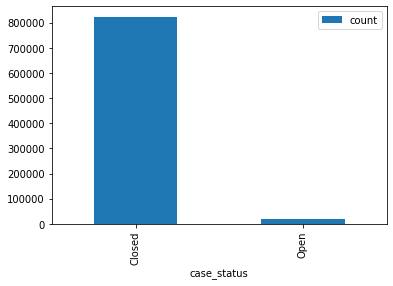

In [11]:
pdf.set_index('case_status').plot.bar()

**What's the average amount of time a case is open?**

In [7]:
df.groupBy('case_status').agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108407461102653|
+-----------+------------------+



**How many cases does each department handle?**

<Figure size 864x648 with 0 Axes>

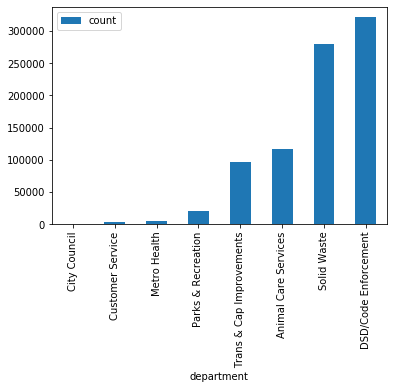

In [32]:
plt.figure(figsize=(12,9))
df.groupBy('department').count().toPandas().sort_values(by='count')\
    .set_index('department').plot.bar()

In [24]:
pdf = df.groupBy('department').pivot('case_status').count().toPandas()
pdf

,department,Closed,Open
0,Solid Waste,277660,1610
1,Animal Care Services,116446,469
2,Trans & Cap Improvements,93962,2231
3,Customer Service,1684,1165
4,Parks & Recreation,19511,396
5,Metro Health,5088,75
6,City Council,4,29
7,DSD/Code Enforcement,309239,12135


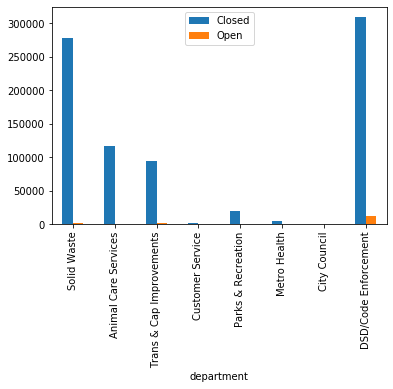

In [25]:
pdf.set_index('department').plot.bar()

[Text(0.5, 1.0, 'Open Cases')]

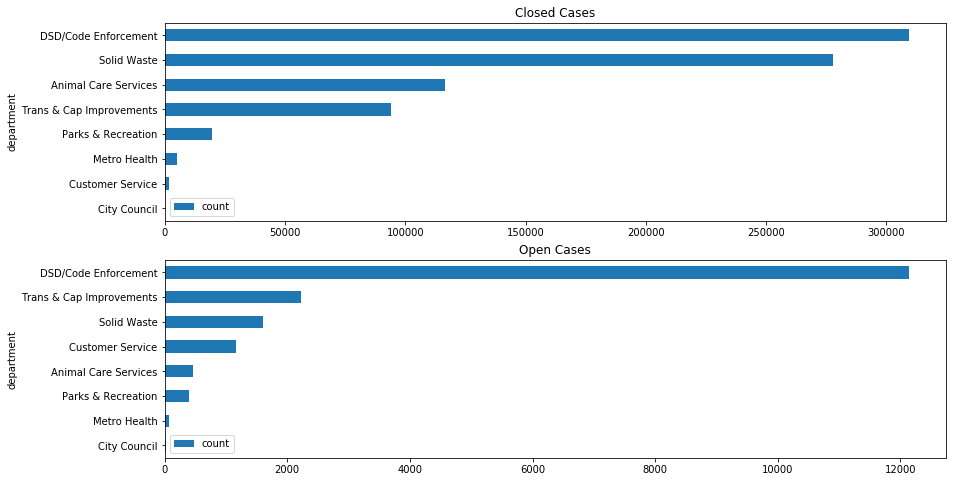

In [26]:
closed_cases = df.filter('case_closed').groupBy('department').count().toPandas()
open_cases = df.filter(expr('! case_closed')).groupBy('department').count().toPandas()

fix, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

closed_cases.set_index('department').sort_values(by='count').plot.barh(ax=ax1)
ax1.set(title='Closed Cases')
open_cases.set_index('department').sort_values(by='count').plot.barh(ax=ax2)
ax2.set(title='Open Cases')

Text(0.5, 0, 'Number of Cases')

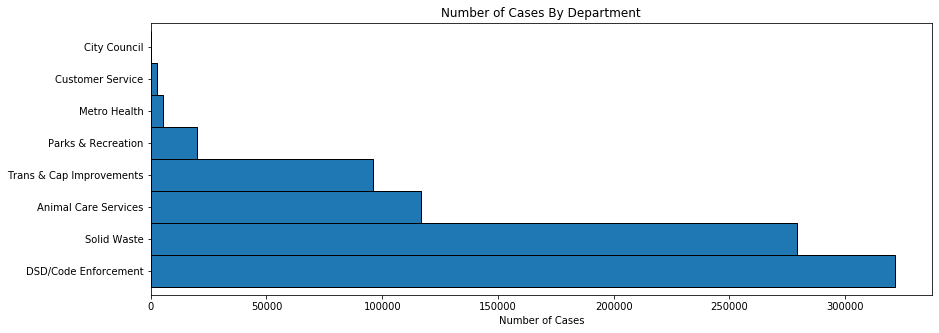

In [27]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")